In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import struct
import functions as datahelper
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
import scipy.io as imread
%matplotlib inline 

In [11]:
def loadpb(filename, model_name='dcgan'):
    """Loads pretrained graph from ProtoBuf file
    Arguments:
        filename - path to ProtoBuf graph definition
        model_name - prefix to assign to loaded graph node names
    Returns:
        graph, graph_def - as per Tensorflow definitions
    """
    with tf.gfile.GFile(filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def,
                            input_map=None,
                            return_elements=None,
                            producer_op_list=None,
                            name=model_name)

    return graph, graph_def

In [12]:
tf.reset_default_graph()

# hyperparameters -- TODO save in config file
BATCH_SIZE=64
z_dim = 100 # random noise vector dimension 

beta1=0.5 # β1 Adam training param
learning_rate = 0.0002
lmda = 0.003 # λ ratio for prior loss


epochs = 5

image_size = 64
channels = 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

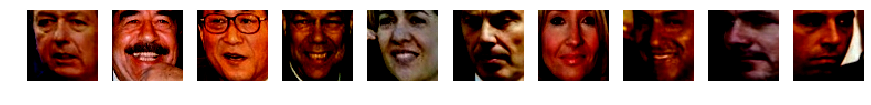

In [13]:
# data TODO


dataset = tf.data.TFRecordDataset(filenames="./data.tfrecord")
dataset  = dataset.map(datahelper.extract_fn)

# dataset = tf.data.TFRecordDataset.from_tensor_slices(dataset)
dataset = dataset.shuffle(buffer_size=300)
dataset = dataset.batch(BATCH_SIZE)


iterator = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)
init_op = iterator.make_initializer(dataset)

# batched data to feed in
image_data = iterator.get_next()
image_data = tf.cast((image_data/255)*2  - 1, dtype=tf.float32)


# visualize original data
with tf.Session() as sess:
    sess.run(init_op)
    real_img = np.array(sess.run(image_data))
    fig, ax = plt.subplots(1,10,figsize=(15,15))
    for i in range(10):
        _img = real_img[i,:,:,:]
        ax[i].imshow(_img)
        ax[i].axis('off')


In [14]:
# load frozen graph
graph, graph_def = loadpb("dcgan-100.pb")

g_in = graph.get_tensor_by_name('dcgan/z:0')
g_out = graph.get_tensor_by_name('dcgan/Tanh:0')
g_loss = graph.get_tensor_by_name('dcgan/Mean_2:0')
d_in = graph.get_tensor_by_name('dcgan/real_images:0')
d_out = graph.get_tensor_by_name('dcgan/Sigmoid:0')


print(np.amax(real_img))

1.0


In [15]:
# sample_img = tf.summary.image('generated_images', generated_images)
write = tf.summary.FileWriter('./summaries')

with tf.Session(graph=graph) as sess:
    z = np.random.randn(BATCH_SIZE, z_dim)
    sample_out = sess.run(g_out, feed_dict={g_in: z})
    write.add_graph(graph)
#     write.add_summary(imgs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


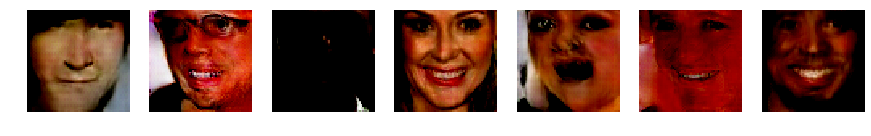

In [16]:
# check if pretrained GAN is working 
fig, ax = plt.subplots(1,7,figsize=(15,15))
for i in range(7):
    img = sample_out[i,:,:,:]
    ax[i].imshow(img)
    ax[i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


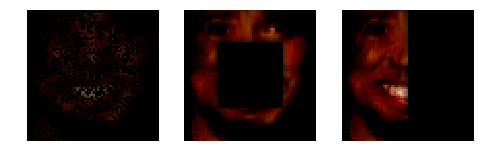

In [17]:
def make_mask(mask_type, weighted_mask = True, rgb = True, img_size = 64, ratio = 0.25, nsize = 7):
    # mask_type can be center, random, or half
    # img_size is int, defaults to 64
    # ratio is number < 0.5, either for amount masked in center or the percentage masked randomly
    mask = np.ones(shape=(img_size, img_size))
    
    assert(ratio < 0.5), "ratio must be less than 0.5"
    
    if mask_type == 'center':
        start = int(img_size*ratio)
        stop = int(img_size*(1-ratio))
        mask[start:stop, start:stop] = 0
    elif mask_type == 'random':
        rand_mask = np.random.randn(img_size, img_size)
        mask[rand_mask < ratio] = 0
    elif mask_type == 'half':
        half = img_size // 2
        mask[:, half:] = 0
    else:
        assert(False), "mask_type must be center, random, or half."
    if weighted_mask:
        ker = np.ones((nsize,nsize), dtype=np.float32)
        ker = ker/np.sum(ker)
        mask = mask * convolve2d(mask, ker, mode='same', boundary='symm')
    
    if not rgb:
        return mask
    else:
        return mask.reshape(img_size, img_size, 1).repeat(3,2)
    
# make mask 3D for rgb


        
        
msk = [make_mask('random'), make_mask('center'), make_mask('half')]



# visualize mask types
fig, ax = plt.subplots(1,3,figsize=(8,8))
for i in range(3):
    newimg = img*msk[i]
    ax[i].imshow(newimg)
    ax[i].axis('off')     
            


In [18]:

                              
#TODO def create_batches for masks & images (convert to initializable iterator)
def single_to_batch(img):
    # fit image or mask to batch size
    img = img.reshape(1, image_size, image_size, channels).repeat(BATCH_SIZE,0)
    return img
                                

# losses
def get_losses(mask_placeholder, images_placeholder,l2 = False, rgb = True):
    # returns either l1 or l2 (context + perceptual) inpaint loss, and the gradient 
    # TODO change to image_placeholder after testing
#     a = mask_placeholder @ g_out
#     b = mask_placeholder @ images_placeholder
    if rgb:
        axis = [1,2,3]
    else:
        axis = [1,2]
            
    if not l2:
      
        context_loss = tf.abs(mask_placeholder * g_out - mask_placeholder * images_placeholder)
        context_loss = tf.reduce_sum(context_loss, axis=axis)
    else:
        context_loss = tf.reduce_sum(tf.square(mask_placeholder * g_out - mask_placeholder * images_placeholder), axis=axis)
        
        
    percept_loss = g_loss
    
    z_loss = context_loss + lmda*percept_loss
    z_gradient = tf.gradients(z_loss, g_in)
    
    
    return z_loss, z_gradient




In [19]:
def get_best_z_img(masks, images, mode = "same"): 
    # run loss, grad, g_out using masks, g_in, and images
    # backpropagate to input z vec and generate images until looks similar
    # mode indicates if same or different images in batch
    z = np.random.randn(BATCH_SIZE, z_dim)
    if mode == "diff":
        vel = np.zeros((BATCH_SIZE, z_dim))
    elif mode == "same":
        vel = 0
    else:
        assert(False), "choose mode as either 'diff' or 'same'"
    iters = 1000 
    momentum = 0.9 
    r = 0.01 # learning rate

    
    with tf.Session(graph=graph) as sess:
        # create batches of masks & images to feed in
        mask_placeholder = tf.placeholder(tf.float32, shape=(BATCH_SIZE,image_size, image_size, channels))
        # real image batches, use if own image input
        images_placeholder = tf.placeholder(tf.float32, shape=(BATCH_SIZE,image_size, image_size, channels))
        
        inpaint_loss, gradient = get_losses(mask_placeholder, images_placeholder)
            
        for i in range(iters):
            feed_dict = {mask_placeholder: masks, images_placeholder: images, g_in: z}
            loss, grad, gen_img = sess.run((inpaint_loss, gradient, g_out), feed_dict=feed_dict)
            
            
            if mode == 'same':
                grad = grad[0]
            
            
            v_prev = vel
            vel = v_prev*momentum - r*grad 
            z += 0.3 * v_prev + 0.7*vel
#             z += v_prev*momentum + vel*(1 + momentum)  --not sure about this

            z = np.clip(z, -1, 1)
            
    return gen_img # change to yield? 
            
        
    
    
    
 

In [20]:
masks = single_to_batch(msk[1]) # centered masks

im = imread('JK_Rowling_0003.png')
im = (im/255)*2  - 1
print(np.amax(im))
print(np.float32(im).dtype)

img_to_fill = single_to_batch(np.float32(im))

gen_imgs = get_best_z_img(masks=masks, images=img_to_fill)

TypeError: 'module' object is not callable

In [ ]:
fig, ax = plt.subplots(1,7,figsize=(15,15))
for i in range(7):
    img = gen_imgs[i,:,:,:]
    ax[i].imshow(img)
    ax[i].axis('off')